<a href="https://colab.research.google.com/github/ParsaPNT128/yelp-recommender/blob/main/yelp_rs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Yelp Recommender System**

## **Data Collection**

In [2]:
!pip install pyspark

In [3]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("Yelp Restaurant Recommendation System") \
    .getOrCreate()

In [4]:
!pip install kaggle

In [5]:
!kaggle datasets download -d yelp-dataset/yelp-dataset

Dataset URL: https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset
License(s): other
100% 4.06G/4.07G [00:48<00:00, 77.1MB/s]
100% 4.07G/4.07G [00:48<00:00, 90.0MB/s]


In [6]:
!unzip /content/yelp-dataset.zip

Archive:  /content/yelp-dataset.zip
  inflating: Dataset_User_Agreement.pdf  
  inflating: yelp_academic_dataset_business.json  
  inflating: yelp_academic_dataset_checkin.json  
  inflating: yelp_academic_dataset_review.json  
  inflating: yelp_academic_dataset_tip.json  
  inflating: yelp_academic_dataset_user.json  


In [7]:
business_df = spark.read.json("yelp_academic_dataset_business.json")
review_df = spark.read.json("yelp_academic_dataset_review.json")
user_df = spark.read.json("yelp_academic_dataset_user.json")

## **Data Preprocessing**

In [8]:
business_df.show(5)
review_df.show(5)
user_df.show(5)

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|         city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|{NULL, NULL, NULL...|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|Santa Barbara|                NULL|      0|34.4266787|-119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
|87 Grasso Plaza S...|{NULL, NULL, NULL...|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|       Affton|{8:0-18:30, 0:0-0...|      1| 38.551126|  -90.335695|    

**Selecting Columns**

In [9]:
business_cols = ['business_id', 'name', 'categories', 'city', 'latitude', 'longitude', 'is_open']
review_cols = ['review_id', 'user_id', 'business_id', 'stars', 'text']
user_cols = ['user_id', 'review_count', 'average_stars', 'name']

In [10]:
business_df = business_df.select(business_cols)
review_df = review_df.select(review_cols)
user_df = user_df.select(user_cols)

**Filtering**

In [11]:
from pyspark.sql.functions import col

rest_df = business_df.filter(col("categories").contains("Restaurants"))
rest_df = rest_df.filter(rest_df["is_open"] == 1)

**Dropping Columns**

In [12]:
rest_df = rest_df.drop("is_open")

In [13]:
rest_df = rest_df.dropna()
review_df = review_df.dropna()
user_df = user_df.dropna()

## **Data Exploration**

In [14]:
rest_df.printSchema()
review_df.printSchema()
user_df.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- city: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)

root
 |-- review_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)

root
 |-- user_id: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- average_stars: double (nullable = true)
 |-- name: string (nullable = true)



In [15]:
rest_df.describe().show()
review_df.describe().show()
user_df.describe().show()

+-------+--------------------+--------------------+--------------------+--------+-----------------+------------------+
|summary|         business_id|                name|          categories|    city|         latitude|         longitude|
+-------+--------------------+--------------------+--------------------+--------+-----------------+------------------+
|  count|               34987|               34987|               34987|   34987|            34987|             34987|
|   mean|                NULL|               956.5|                NULL|    NULL|37.05655230307231|-87.88063364217523|
| stddev|                NULL|  1054.2962107491423|                NULL|    NULL|6.094541891225122|13.773586060717024|
|    min|---kPU91CF4Lq2-Wl...|#1 Mongolian BBQ ...|Acai Bowls, Asian...|Abington|    27.5644572387|       -120.083748|
|    max|zznZqH9CiAznbkV6f...|              ā café|Yoga, Food, Activ...| wimauma|       53.6791969|       -74.6802499|
+-------+--------------------+------------------

In [17]:
!pip install matplotlib

In [18]:
!pip install wordcloud

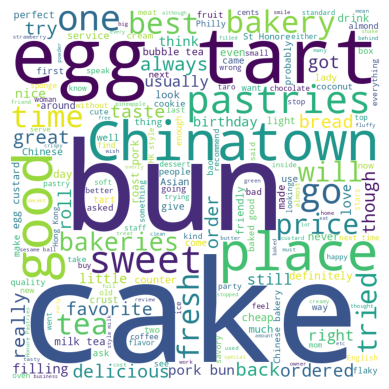

In [29]:
# Creates a word cloud for a restaurants reviews
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from pyspark.sql.functions import col

def create_wordcloud(df):
  review_list = df.select('text').toPandas()['text'].tolist()
  all_review = ''.join(review_list)

  wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = STOPWORDS,
                min_font_size = 10).generate(all_review)

  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

rest = input("Enter the business name: ")
rest_data = rest_df.filter(rest_df["name"] == rest)

if rest_data.count():
  review_data = rest_data.join(review_df, on="business_id", how="inner")

  if b.count():
    create_wordcloud(review_data)

  else:
    print("No reviews found.")

else:
  print("Business not found.")